# VQ-VAE on Fashion MNIST

Author: Gabriele LORENZO

In [152]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We define the hyperparameters

In [154]:
# parameters used in the VQ-VAE paper
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATES = [
    1e-3
]  # can use a list of learning rates to try out different values, this is the best value I found
N_CHANNELS = 1
HIDDEN_DIM = 128
NUM_EMBEDDINGS = 512
EMBEDDING_DIM = 64
N_RES_LAYERS = 2
COMMITMENT_COST = 0.25

### Load Fashion MNIST dataset


In [155]:
train_set = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_set = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
)

In [156]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False
)

We visualize a sample of the dataset to understand the structure of the data.

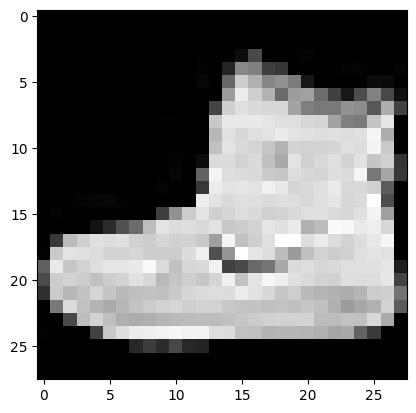

In [157]:
image, _ = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")

Here instead we print some initial information about the dataset classes:

In [158]:
print(f"Classes: {train_set.classes}")
print(f"Number of classes: {len(train_set.classes)}")
print(f"Distribution of classes: {np.bincount(train_set.targets)}")

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of classes: 10
Distribution of classes: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


As we can see, the dataset is composed of images of 28x28 pixels in grayscale.

The images are divided into 10 classes, each representing a different type of clothing.
Moreover the classes are balanced, with 6000 images for each class.

### Exploratory Data Analysis


In this section we will perform some exploratory data analysis to understand the structure of the data.

We will use dimensionality reduction techniques to visualize the data in 2D.

We expect to see clusters of similar classes: for example, shoes and sandals should be close to each other.

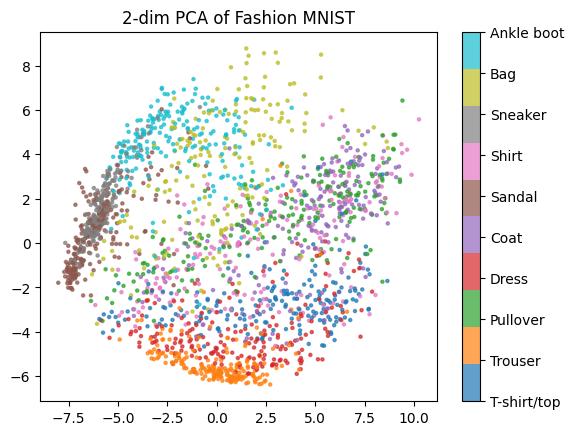

In [159]:
from sklearn.decomposition import PCA

np.random.seed(0)
indices = np.random.choice(len(train_set), 2000, replace=False)
train_subset = torch.utils.data.Subset(train_set, indices)

images_flat = np.array(
    [image.flatten().numpy() for image, _ in train_subset], dtype=np.float32
)
labels = np.array([label for _, label in train_subset])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(images_flat)

scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1], c=labels, cmap="tab10", alpha=0.7, s=5
)
colorbar = plt.colorbar(scatter)
colorbar.set_ticks(range(10))
colorbar.set_ticklabels(train_set.classes)
plt.title("2-dim PCA of Fashion MNIST")
plt.show()

As we can see from the plot, the classes are not well separated. This could be due to the fact that taking only 2 dimensions is not enough to separate the classes.

We will try to use more advanced techniques to visualize the data in 2D such as UMAP and t-SNE.

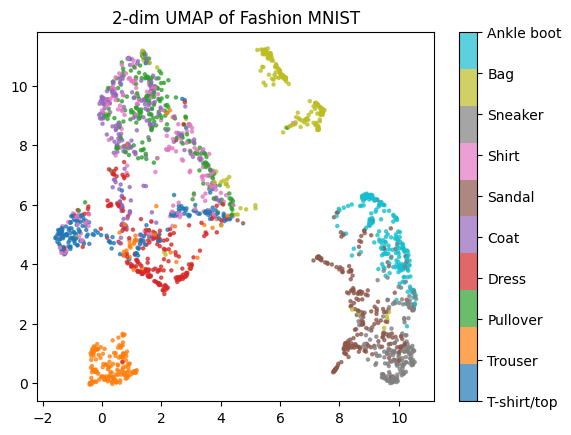

In [160]:
import umap

reducer = umap.UMAP()
umap_result = reducer.fit_transform(images_flat)

scatter = plt.scatter(
    umap_result[:, 0], umap_result[:, 1], c=labels, cmap="tab10", alpha=0.7, s=5
)
colorbar = plt.colorbar(scatter)
colorbar.set_ticks(range(10))
colorbar.set_ticklabels(train_set.classes)
plt.title("2-dim UMAP of Fashion MNIST")
plt.show()

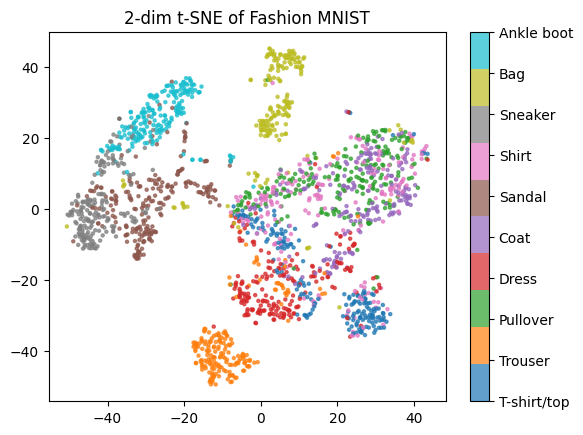

In [161]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(images_flat)

scatter = plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap="tab10", alpha=0.7, s=5
)
colorbar = plt.colorbar(scatter)
colorbar.set_ticks(range(10))
colorbar.set_ticklabels(train_set.classes)
plt.title("2-dim t-SNE of Fashion MNIST")
plt.show()

This time we can see that the classes are better separated. Both UMAP and t-SNE are able to separate the classes in a more meaningful way.

We can observe 4 main clusters: shoes, shirts, trousers and bags.

### Define the model


In [162]:
class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, res_h_dim):
        super(ResidualLayer, self).__init__()

        self.res_block = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_dim, res_h_dim, kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(res_h_dim, in_dim, kernel_size=1, stride=1, bias=False),
        )

    def forward(self, x):
        return x + self.res_block(x)


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()

        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, res_h_dim) for _ in range(n_res_layers)]
        )

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        return F.relu(x)

In [163]:
class Encoder(nn.Module):
    """
    Encoder module for extracting latent representations from input data.

    Args:
        n_channels (int): Number of input channels (e.g., 1 for grayscale images, 3 for RGB).
        hidden_dim (int): Dimension of hidden layers in the encoder.
        output_dim (int): Dimension of the latent representation.
        n_res_layers (int): Number of residual layers to use in the encoder.

    Architecture:
        - Three convolutional layers with downsampling and ReLU activations.
        - One residual stack for feature refinement.
        - A final convolutional layer projecting to the latent space.

    Input:
        torch.Tensor: Input tensor of shape (batch_size, n_channels, height, width).

    Output:
        torch.Tensor: Latent representation tensor of shape (batch_size, output_dim, height // 4, width // 4).
    """

    def __init__(self, n_channels, hidden_dim, output_dim, n_res_layers):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(
                n_channels, hidden_dim // 2, kernel_size=4, stride=2, padding=1
            ),  # Input: [n_channels, 28, 28] Output: [hidden_dim // 2, 14, 14]
            nn.BatchNorm2d(hidden_dim // 2),
            nn.ReLU(),
            nn.Conv2d(
                hidden_dim // 2, hidden_dim, kernel_size=4, stride=2, padding=1
            ),  # Input: [hidden_dim // 2, 14, 14] Output: [hidden_dim, 7, 7]
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(
                hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1
            ),  # Input: [hidden_dim, 7, 7] Output: [hidden_dim, 7, 7]
            ResidualStack(
                hidden_dim, hidden_dim, n_res_layers
            ),  # Input: [hidden_dim, 7, 7] Output: [hidden_dim, 7, 7]
        )

    def forward(self, x):
        return self.encoder(x)

In [164]:
# Used https://shashank7-iitd.medium.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a
# as a reference for the implementation of the VectorQuantizer class


class VectorQuantizer(nn.Module):
    """
    Vector Quantizer module for discretizing latent representations using a codebook.

    Args:
        num_embeddings (int): Number of embeddings in the codebook.
        embedding_dim (int): Dimension of each embedding vector.
        commitment_cost (float): Weight of the commitment loss, ensuring latent codes match inputs.

    Forward Method:
        - Flattens input data and computes distances between inputs and embedding vectors.
        - Finds the nearest embedding for each input and reconstructs the quantized representation.
        - Computes the quantization loss and perplexity of the embedding usage.

    Input:
        torch.Tensor: Input tensor of shape (batch_size, channels, height, width).

    Output:
        Tuple:
            - loss (torch.Tensor): Quantization loss.
            - quantized (torch.Tensor): Quantized output tensor of shape (batch_size, channels, height, width).
            - perplexity (torch.Tensor): Measure of the diversity of embeddings used.
            - encodings (torch.Tensor): One-hot encoding of the selected embeddings.
    """

    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        # the dictionary of embeddings
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(
            -1 / self.num_embeddings, 1 / self.num_embeddings
        )
        self.commitment_cost = commitment_cost

    def forward(self, inputs: torch.Tensor):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate Eucledian distance between input and embeddings
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.embedding.weight.t())
        )

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        # one-hot encoding
        encodings = torch.zeros(
            encoding_indices.shape[0], self.num_embeddings, device=inputs.device
        )
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [165]:
class Decoder(nn.Module):
    """
    Decoder module for reconstructing input data from latent representations.

    Args:
        input_dim (int): Dimension of the input latent representation.
        hidden_dim (int): Dimension of hidden layers in the decoder.
        n_channels (int): Number of output channels (e.g., 1 for grayscale images, 3 for RGB).
        n_res_layers (int): Number of residual layers to use in the decoder.

    Architecture:
        - One transposed convolutional layer to match the latent input shape.
        - One residual stack for feature refinement.
        - Two transposed convolutional layers for upsampling.
        - A final sigmoid activation for output normalization (range: [0, 1]).

    Input:
        torch.Tensor: Latent representation tensor of shape (batch_size, input_dim, height, width).

    Output:
        torch.Tensor: Reconstructed data tensor of shape (batch_size, n_channels, height * 4, width * 4).
    """

    def __init__(self, input_dim, hidden_dim, n_channels, n_res_layers):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv2d(
                input_dim, hidden_dim, kernel_size=3, stride=1, padding=1
            ),  # Input: [input_dim, 7, 7] Output: [hidden_dim, 7, 7]
            ResidualStack(
                hidden_dim, hidden_dim, n_res_layers
            ),  # Input: [hidden_dim, 7, 7] Output: [hidden_dim, 7, 7]
            nn.ConvTranspose2d(
                hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1
            ),  # Input: [hidden_dim, 7, 7] Output: [hidden_dim // 2, 14, 14]
            nn.BatchNorm2d(hidden_dim // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                hidden_dim // 2, n_channels, kernel_size=4, stride=2, padding=1
            ),  # Input: [hidden_dim // 2, 14, 14] Output: [n_channels, 28, 28]
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [166]:
class VQVAE(nn.Module):
    """
    Vector Quantized Variational Autoencoder (VQVAE) for learning discrete latent representations.

    This model consists of three main components:
        1. Encoder: Maps the input data to a continuous latent space.
        2. Vector Quantizer: Discretizes the latent representations using a learned codebook.
        3. Decoder: Reconstructs the input data from the quantized latent representations.

    Args:
        n_channels (int): Number of input channels (e.g., 1 for grayscale, 3 for RGB).
        hidden_dim (int): Dimension of hidden layers in the encoder and decoder.
        num_embeddings (int): Number of embeddings in the quantization codebook.
        embedding_dim (int): Dimension of each embedding vector in the codebook.
        n_res_layers (int): Number of residual layers in the encoder and decoder.
        commitment_cost (float): Weight of the commitment loss in the quantization loss.

    Forward Method:
        - Encodes the input into a latent representation.
        - Quantizes the latent representation using the vector quantizer.
        - Reconstructs the input from the quantized latent representation.
        - Returns the reconstructed input, quantization loss, and perplexity.

    Input:
        torch.Tensor: Input tensor of shape (batch_size, n_channels, height, width).

    Output:
        Tuple:
            - x_recon (torch.Tensor): Reconstructed tensor of shape (batch_size, n_channels, height, width).
            - loss (torch.Tensor): Quantization loss.
            - perplexity (torch.Tensor): Measure of the diversity of embeddings used.
    """

    def __init__(
        self,
        n_channels,
        hidden_dim,
        num_embeddings,
        embedding_dim,
        n_res_layers,
        commitment_cost,
    ):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(
            n_channels, hidden_dim, embedding_dim, n_res_layers
        )  # Input: [n_channels, 28, 28], Output: [embedding_dim, 7, 7]
        self.pre_vq_conv = nn.Sequential(
            nn.Conv2d(hidden_dim, embedding_dim, kernel_size=1, stride=1)
        )  # Input: [embedding_dim, 7, 7], Output: [embedding_dim, 7, 7]
        self.quantizer = VectorQuantizer(
            num_embeddings, embedding_dim, commitment_cost
        )  #
        self.decoder = Decoder(
            embedding_dim, hidden_dim, n_channels, n_res_layers
        )  # Input: [embedding_dim, 7, 7], Output: [n_channels, 28, 28]

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss, quantized, perplexity, _ = self.quantizer(z)
        x_recon = self.decoder(quantized)

        return x_recon, loss, perplexity

### Training loop


In [167]:
model = VQVAE(
    N_CHANNELS, HIDDEN_DIM, NUM_EMBEDDINGS, EMBEDDING_DIM, N_RES_LAYERS, COMMITMENT_COST
).to(device)
print(model)

VQVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (pre_vq_conv): Sequential(
    (0): Conv2d(128, 64

In [168]:
def train(optimizer, verbose):
    model.train()
    loss_list = []
    perplexity_list = []

    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        x_recon, loss, perplexity = model(data)
        recon_error = F.mse_loss(x_recon, data)
        loss = recon_error + loss

        perplexity_list.append(perplexity.item())
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 100 == 0 and verbose == True:
            print(
                f"Step: {i}, Loss: {loss.item()}, Recon Error: {recon_error.item()}, Perplexity: {perplexity.item()}"
            )
    f"Step: {i}, Loss: {loss.item()}, Recon Error: {recon_error.item()}, Perplexity: {perplexity.item()}"

    return loss_list, perplexity_list

We will train the model and search for the best learning rate.

In [169]:
best_lr = None
best_loss = float("inf")

if len(LEARNING_RATES) == 1:
    best_lr = LEARNING_RATES[0]
else:
    for lr in LEARNING_RATES:
        print(f"Training with learning rate: {lr}")
        model = VQVAE(
            N_CHANNELS,
            HIDDEN_DIM,
            NUM_EMBEDDINGS,
            EMBEDDING_DIM,
            N_RES_LAYERS,
            COMMITMENT_COST,
        ).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for e in range(EPOCHS):
            loss_list, _ = train(optimizer, verbose=False)
            print(f"Epoch: {e} - Loss: {loss_list[-1]}")

            if loss_list[-1] < best_loss:
                best_loss = loss_list[-1]
                best_lr = lr

    print(f"Best learning rate: {best_lr}")

In [170]:
model = VQVAE(
    N_CHANNELS, HIDDEN_DIM, NUM_EMBEDDINGS, EMBEDDING_DIM, N_RES_LAYERS, COMMITMENT_COST
).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr)

tot_perplexity_list = []
tot_loss_list = []

for e in range(EPOCHS):
    print(f"Epoch: {e}")
    epoch_loss_list, epoch_perplexity_list = train(optimizer, verbose=True)
    tot_perplexity_list.extend(epoch_perplexity_list)
    tot_loss_list.extend(epoch_loss_list)

torch.save(model.state_dict(), "vqvae_model.pth")

Epoch: 0
Step: 0, Loss: 0.29241323471069336, Recon Error: 0.25355955958366394, Perplexity: 21.70844841003418
Step: 100, Loss: 0.3384366035461426, Recon Error: 0.02497182972729206, Perplexity: 6.171560764312744
Step: 200, Loss: 0.05230219289660454, Recon Error: 0.017332080751657486, Perplexity: 14.940046310424805
Step: 300, Loss: 0.03211501985788345, Recon Error: 0.014493467286229134, Perplexity: 25.199071884155273
Step: 400, Loss: 0.020270682871341705, Recon Error: 0.011252718977630138, Perplexity: 32.763702392578125
Epoch: 1
Step: 0, Loss: 0.01899106614291668, Recon Error: 0.011426957324147224, Perplexity: 38.46091079711914
Step: 100, Loss: 0.01622866280376911, Recon Error: 0.010175522416830063, Perplexity: 41.89412307739258
Step: 200, Loss: 0.014806365594267845, Recon Error: 0.008801340125501156, Perplexity: 49.94417190551758
Step: 300, Loss: 0.013851568102836609, Recon Error: 0.008807619102299213, Perplexity: 56.30211639404297
Step: 400, Loss: 0.013848362490534782, Recon Error: 0.00

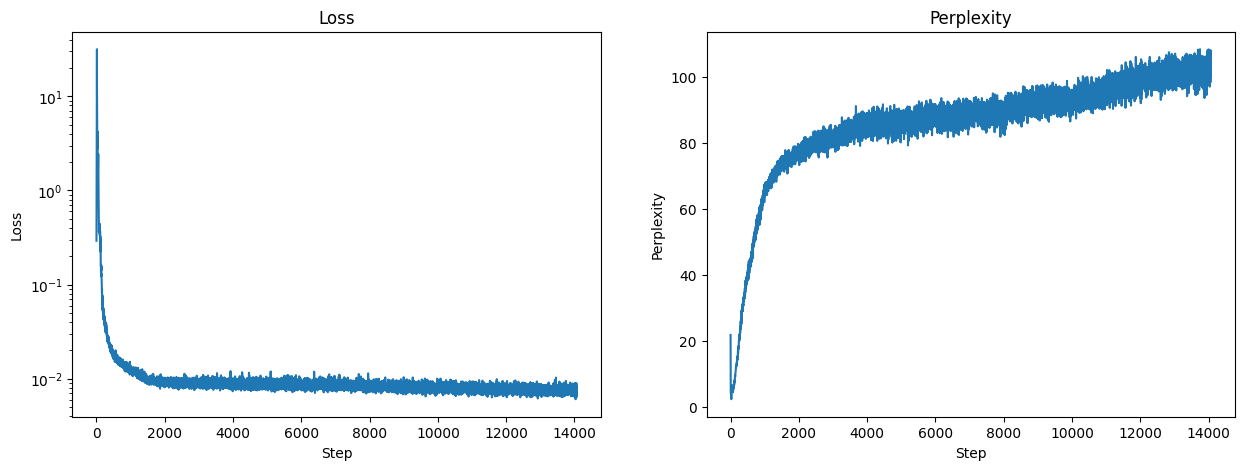

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(tot_loss_list)
ax[0].set_title("Loss")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].set_yscale("log")

ax[1].plot(tot_perplexity_list)
ax[1].set_title("Perplexity")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Perplexity")

plt.show()

As we can see from the plot, the loss is decreasing over time, which means that the model is learning.

Moreover, the perplexity (how many embeddings are used) is increasing over time. Typically when $\frac{\text{NUM\_EMBEDDINGS}}{10} \leq \text{perplexity} \leq \frac{\text{NUM\_EMBEDDINGS}}{3}$ we have a good perplexity (in our case $NUM\_EMBEDDINGS = 512$).


### Analysys of the latent space

Let's start by analyzing the continuous latent space (e.g. the output of the encoder).

In [202]:
model = VQVAE(
    N_CHANNELS, HIDDEN_DIM, NUM_EMBEDDINGS, EMBEDDING_DIM, N_RES_LAYERS, COMMITMENT_COST
).to(device)
model.load_state_dict(torch.load("vqvae_model.pth"))
model.eval()

latent_space = []
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        z = model.encoder(data)
        latent_space.append(z)

latent_space = torch.cat(latent_space, dim=0)
latent_space = latent_space.view(latent_space.size(0), -1).cpu().numpy()

In [203]:
np.random.seed(0)
indices = np.random.choice(len(latent_space), 2000, replace=False)
latent_space_subset = latent_space[indices]
sampled_labels = [train_set.targets[idx] for idx in indices]
labels = np.array(sampled_labels)

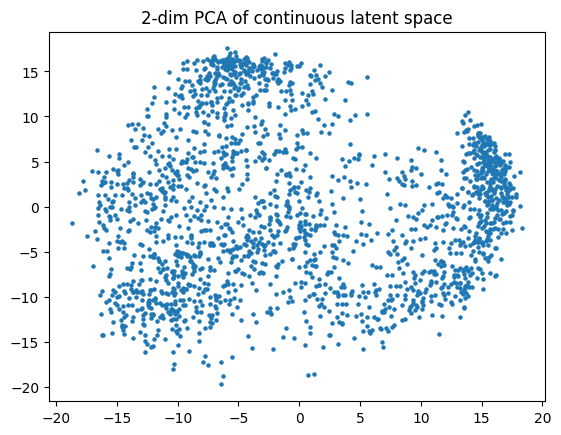

In [204]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_space_subset)

scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], s=5)
plt.title("2-dim PCA of continuous latent space")
plt.show()

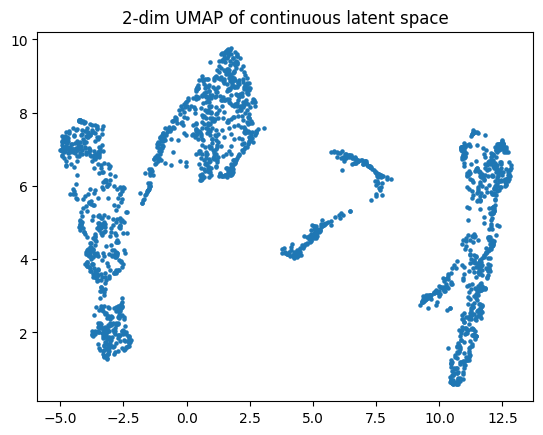

In [205]:
reducer = umap.UMAP()
umap_result = reducer.fit_transform(latent_space_subset)

scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5)
plt.title("2-dim UMAP of continuous latent space")
plt.show()

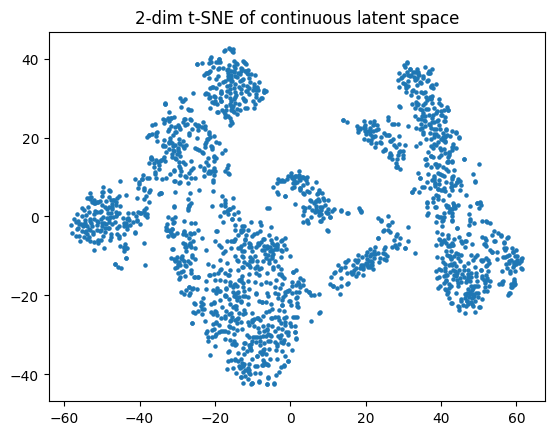

In [206]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(latent_space_subset)

scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=5)
plt.title("2-dim t-SNE of continuous latent space")
plt.show()

We can see that the continuous latent space is well separated. This means that the model is able to learn a good representation of the data.

However, the structure of the clusters resembles only partially the structure of the clusters of the original dataset.

Now we will procede to analyze the discrete latent space (e.g. the output of the quantizer) and see if we get some improvements.

In [207]:
model.eval()
discrete_latent_space = []

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        z = model.encoder(data)
        z = model.pre_vq_conv(z)
        _, encodings, _, _ = model.quantizer(z)

        discrete_latent_space.append(encodings.view(encodings.size(0), -1))

discrete_latent_space = torch.cat(discrete_latent_space, dim=0)
discrete_latent_space = discrete_latent_space.cpu().numpy()

In [208]:
np.random.seed(0)
indices = np.random.choice(len(discrete_latent_space), 2000, replace=False)
discrete_latent_space_subset = discrete_latent_space[indices]
sampled_labels = [train_set.targets[idx] for idx in indices]
labels = np.array(sampled_labels)

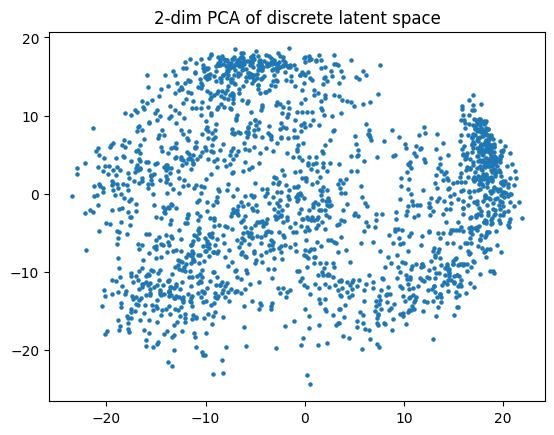

In [209]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(discrete_latent_space_subset)

scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], s=5)
plt.title("2-dim PCA of discrete latent space")
plt.show()

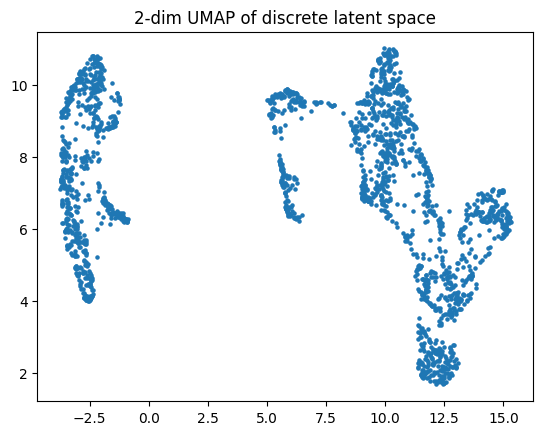

In [210]:
UMAP = umap.UMAP()
umap_result = UMAP.fit_transform(discrete_latent_space_subset)

scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5)
plt.title("2-dim UMAP of discrete latent space")
plt.show()

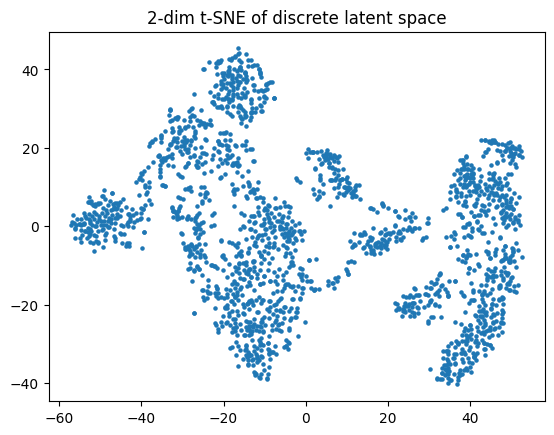

In [211]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(discrete_latent_space_subset)

scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=5)
plt.title("2-dim t-SNE of discrete latent space")
plt.show()

Analyzing the discrete latent space we can see that the embeddings are well separated.

We also observe a similarity between the clusters of the discrete embeddings and the clusters of the original test set (the plots differ only by a rotation).
This similarity is more evident when analyzing the discrete embeddings. This is a sign that the discretization of the latent space is working well.

### Evaluation the model on the test set


Now that we have trained the model, we can evaluate it on the test set.

We will compute the reconstruction error and the structural similarity index (SSIM) between the original and reconstructed images.

In [212]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

model.eval()
x_recon_imgs = []
ssim_vals = []
mse_vals = []

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        x_recon, _, _ = model(data)
        x_recon_imgs.append(x_recon)

        data_np = data.cpu().numpy().squeeze(1)
        recon_np = x_recon.cpu().numpy().squeeze(1)

        for j in range(data_np.shape[0]):
            ssim_score = ssim(data_np[j], recon_np[j], data_range=1.0)
            mse_score = mean_squared_error(data_np[j].flatten(), recon_np[j].flatten())

            ssim_vals.append(ssim_score)
            mse_vals.append(mse_score)


avg_ssim = np.mean(ssim_vals)
avg_mse = np.mean(mse_vals)
x_recon_imgs = torch.cat(x_recon_imgs, dim=0)

print(f"Average SSIM: {avg_ssim:.4f}, Average MSE: {avg_mse:.4f}")

Average SSIM: 0.8984, Average MSE: 0.0038


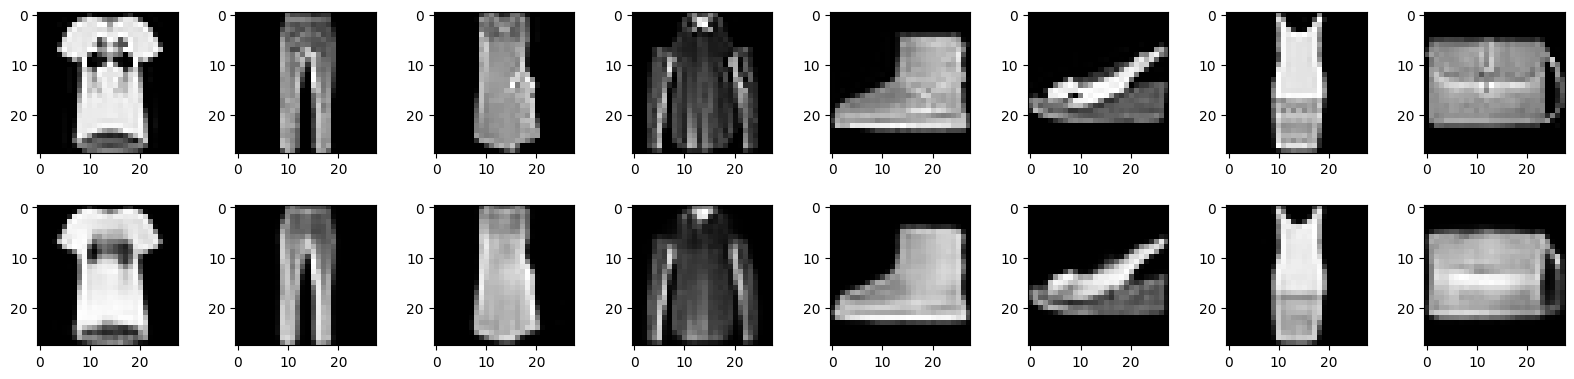

In [213]:
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.tight_layout()

indices = torch.randint(0, 10000, (8,))
for i, idx in enumerate(indices):
    axs[0, i].imshow(test_set[idx][0].squeeze(), cmap="gray")
    axs[1, i].imshow(x_recon_imgs[idx].squeeze().cpu(), cmap="gray")

plt.show()

As we can see, the model is able to reconstruct the images with a low MSE and high SSIM.

This means that the model is able to capture the structure of the images and reconstruct them with high fidelity.